# HW 2. Элементарные методы анализа временных рядов

Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox

# I monthly-us-auto-registration

In [25]:
monthly_us_auto_registration = pd.read_csv("monthly-us-auto-registration-tho.csv", sep=';')

series = pd.read_csv("monthly-us-auto-registration-tho.csv", sep=';')["Count"]

In [10]:
def plot_ts_and_points(ts, start_point, step):
    new_series = [None for i in range(len(ts))]
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')

In [15]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [16]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  -1.225039
p-value                          0.662733
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


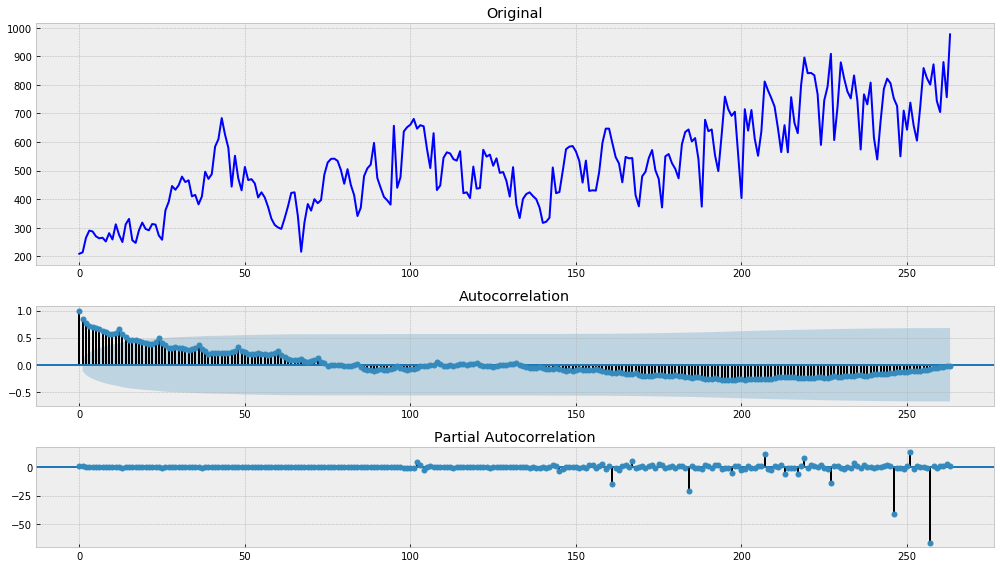

In [17]:
tsplot(series)

# Двойное экспоненциальное сглаживание

Ряд $y_t$ можно представить в виде суммы $l_t$ (уровня) и $s_t$ (тренда). По сути - тренд - это основное направление движения ряда, а уровень - колебание вокруг этого тренда.

Для предсказания уровня мы используем подход на основе классического EMA:

$l_t = \alpha y_t + (1-\alpha)(l_{t-1} + s_{t-1})$

Для прогноза тренда используем так же EMA и простое соображение: историческое значение тренда - это историческое значение тренда, а текущее значение тренда - это изменение уровня. Получим такую формулу:

$s_t = \beta (l_t - l_{t-1}) + (1 - \beta) s_{t-1}$

Итоговый ряд предсказываем по следующей формуле

$\hat{y}_{t+1} = l_t + s_t$

In [34]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [35]:
def plot_dema(alpha, beta):
    dema = double_ema(monthly_us_auto_registration["Count"], alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(monthly_us_auto_registration["Count"], color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

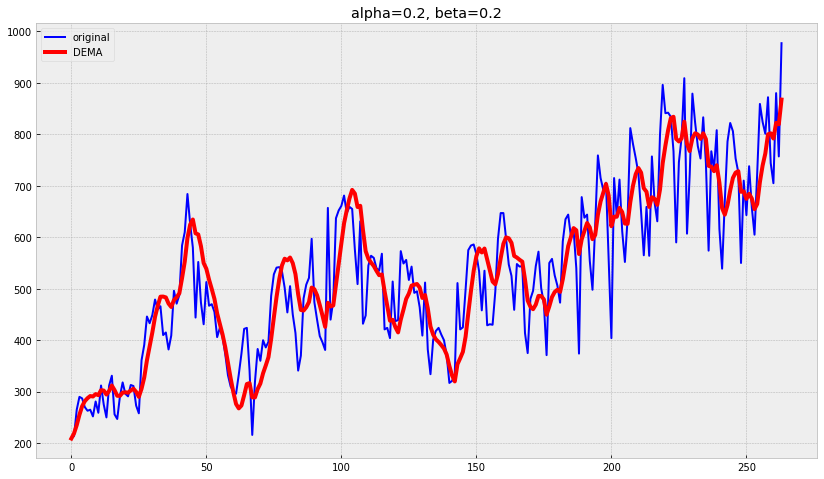

In [36]:
plot_dema(0.2, 0.2) #влияние на уровень, влияние на тренд

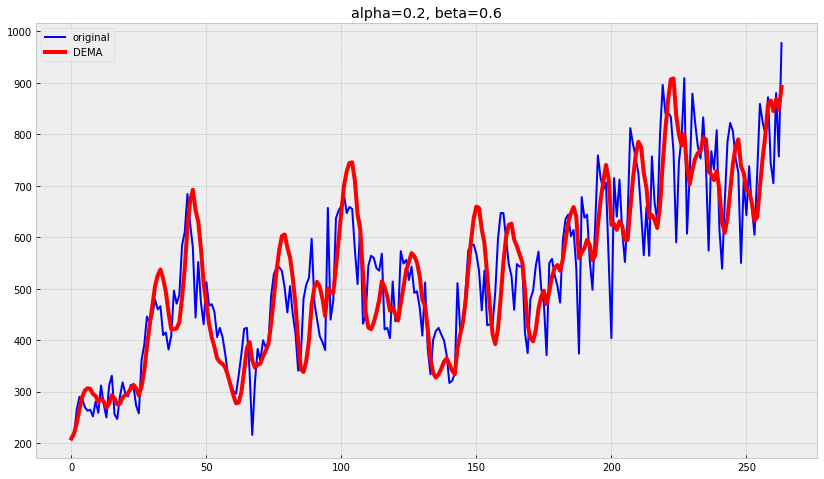

In [37]:
plot_dema(0.2, 0.6) #$\alpha$ отвечает за сглаживание ряда вокруг тренда, $\beta$ - за сглаживание самого тренда. 
                    #Чем больше значения, тем более значимыми будут последние наблюдения и менее значимой будет история.

In [40]:
#функция, которая предсказывает 5 наблюдений ряда на основе double_ema
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)

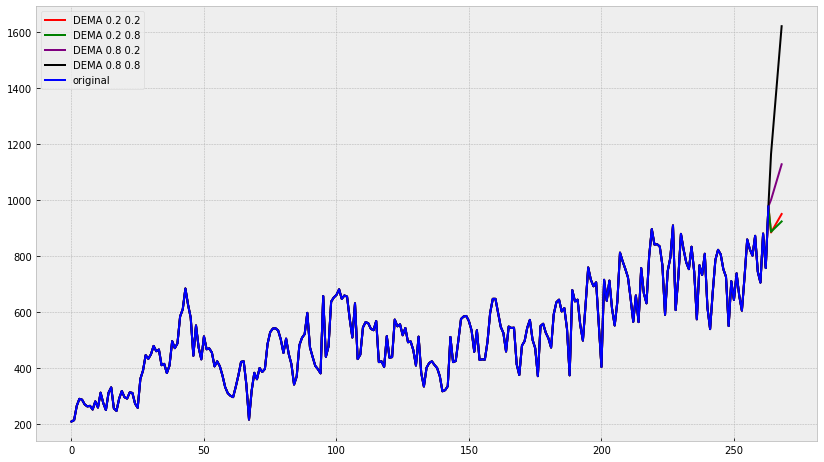

In [41]:
alphas = [0.2,0.2,0.8,0.8]
bettas = [0.2,0.8,0.2,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = double_ema_with_preds(monthly_us_auto_registration["Count"], alphas[i], bettas[i], 5)
        plt.plot(ser, color=colors[i], linewidth='2', label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.plot(monthly_us_auto_registration["Count"], color='blue',label='original')
    plt.legend()

# Хольт-Винтерс

Суть метода в том, что начинаем еще учитывать сезонность. Она учитывается в виде третьей компоненты.

**Важно** - метод применим только в случае сезонности. Если ее нет - метод хольта-винтерса не даст хороших результатов;

$l_t = \alpha(y_t - p_{t-\tau}) + (1-\alpha)(l_{t-1} + s_{t-1})$


$s_t = \beta(l_t - l_{t-1}) + (1-\beta)s_{t-1}$

$p_t = \gamma(y_t - l_t) + (1-\gamma)p_{t-\tau}$

$\hat{y}_{t+m} = l_x + ms_t + p_{t-\tau+1+(m-1)mod\tau}$

Сезонная компонента $p_t$ объясняет повторяющиеся колебания вокруг уровня и тренда; ее параметр - период, после которого начинаются повторения колебаний. Для каждого наблюдения в сезоне формируется своя компонента, например, если длина сезона составляет 3, то мы получим 3 сезонные компоненты.

В уровене из значения ряда теперь вычитается сезонная компонента;

Тренд остаётся без изменений;

Сезонная компонента зависит от текущего значения ряда за вычетом уровня и от предыдущего значения компоненты.

**При сглаживании сезонной компоненты - она сглаживается только со своими измерениями**

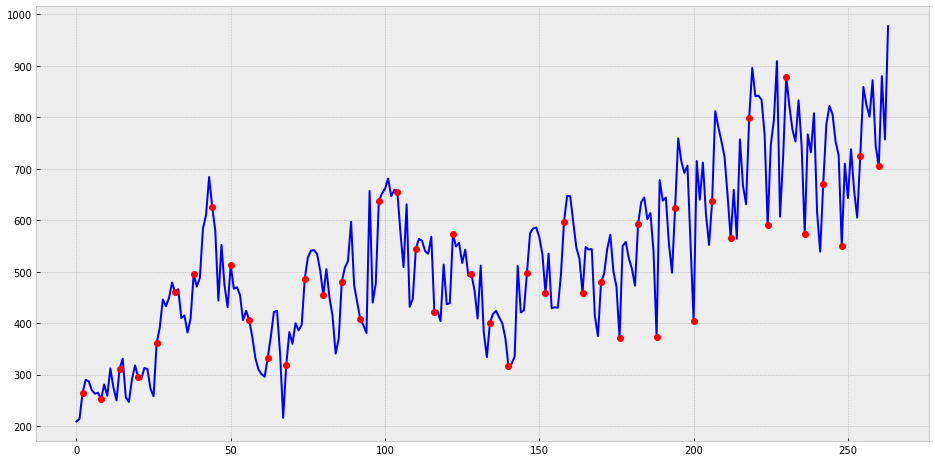

In [50]:
#Рассмотрим наличие сезонности на графике исследуемого ряда
plot_ts_and_points(series, 2, 6)

In [51]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [52]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [53]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [54]:
def plot_tema(alpha, beta, gamma, ser=monthly_us_auto_registration["Count"], ser_to_plot=monthly_us_auto_registration["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

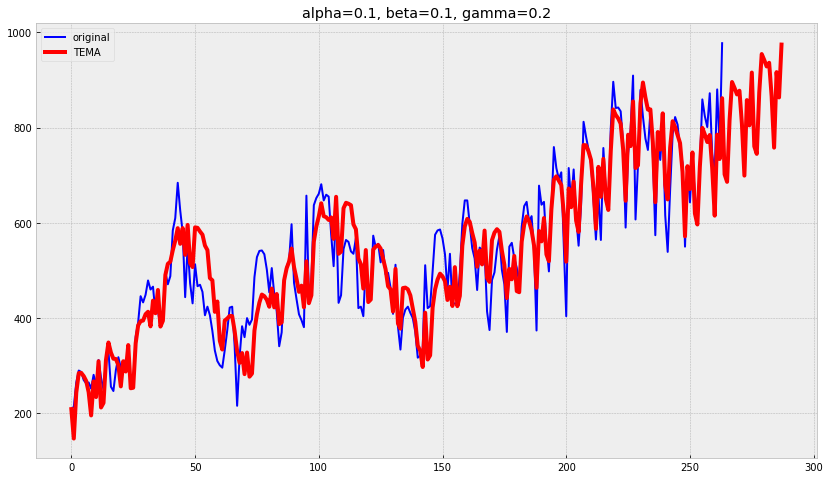

In [55]:
plot_tema(0.1, 0.1, 0.2)

# Подбор параметров

Что значит, что наша модель лучше всего приближает исходные данные? Это значит, что минимизируется некоторая функция ошибки. Мы, для простоты, будет считать стандарнтый RMSE:

$RMSE =  \sqrt {1/n \sum^N_{i=1} (\hat{y}_i - y_i)^2}$

Алгоритм поиска стандартный - метод градиентного спуска. Считаем производный по каждому из параметров и спускаемся в сторону минимума.

In [58]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [59]:
series = monthly_us_auto_registration["Count"]

In [76]:
train, test, val = series[:60], series[60:70], series[70:]

In [77]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [78]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [79]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 4504.317865620415
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.04591891e-02,  9.84933822e+03, -3.63797881e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 96
      nit: 17
   status: 0
  success: True
        x: array([0.54827623, 0.        , 0.62846746])


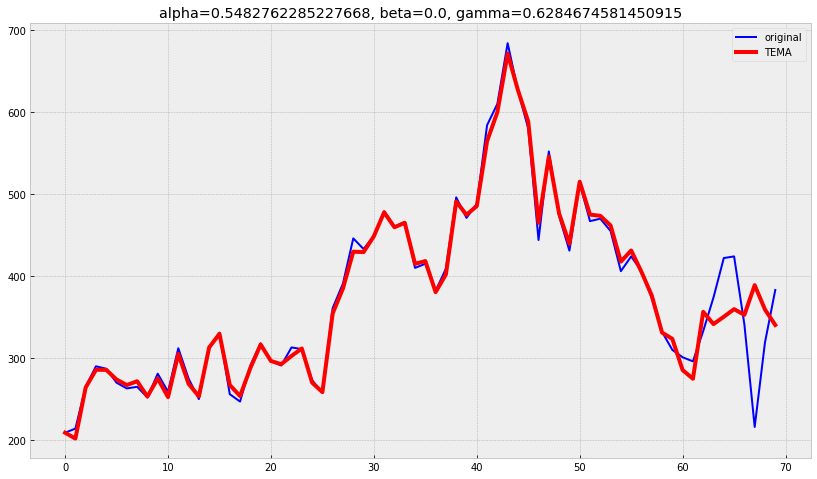

In [80]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:70], n_preds=len(test))

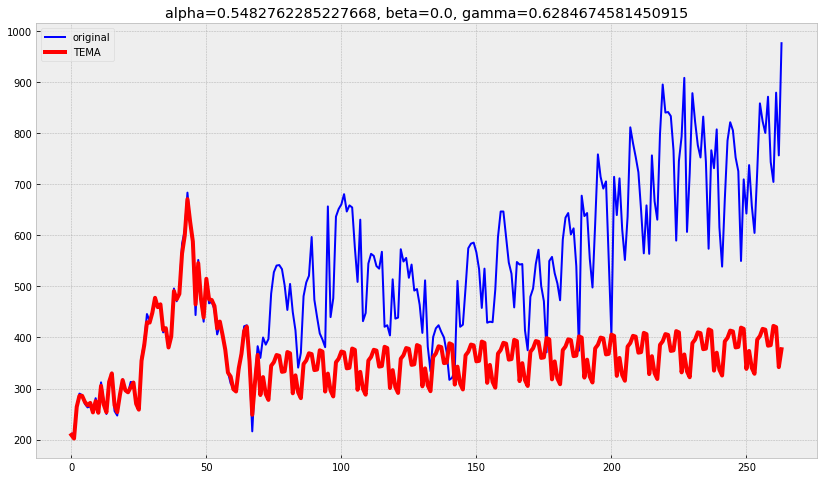

In [81]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:70], ser_to_plot=series, n_preds=len(val))

### Практика 7. Напишите функцию, которая подбирает оптимальные параметры для double_ema и ряда Monthly Boston armed robberies

In [82]:
def mse_double(X):
    alpha, beta = X
    result = double_ema(train, 12, alpha, beta, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [83]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [86]:
opt_double = minimize(mse, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

ValueError: length of x0 != length of bounds

In [85]:
alpha_opt, beta_opt, gamma_opt = opt_double.x
print(opt_double)

NameError: name 'opt_double' is not defined

# Кросс-валидация

Проблема кросс-валидации на временных рядах состоит в том, что случайно перемешивать в фолдах значения всего ряда нельзя. Т.к. он имеет временную структуру, и ее надо сохранять (иначе потеряются все взаимосвязи наблюдений);

Будем делать кросс-валидацию на скользящем окне.

Суть достаточно проста:
1. Берем t измерений
2. Делаем прогноз на n измерений вперед и считаем ошибку
3. Берем t+n измерений
4. Делаем прогноз на n измерений вперед и считаем ошибку
5. Берем t+2*n измерений
6. Делаем прогноз на n измерений вперед и считаем ошибку
...

In [46]:
train, val = series[:65], series[65:]

In [47]:
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

In [48]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [49]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.2191900338836371
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.97095681e-05, -1.74860126e-07,  4.37094805e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 224
      nit: 45
   status: 0
  success: True
        x: array([0.09054065, 0.24441135, 0.89935976])


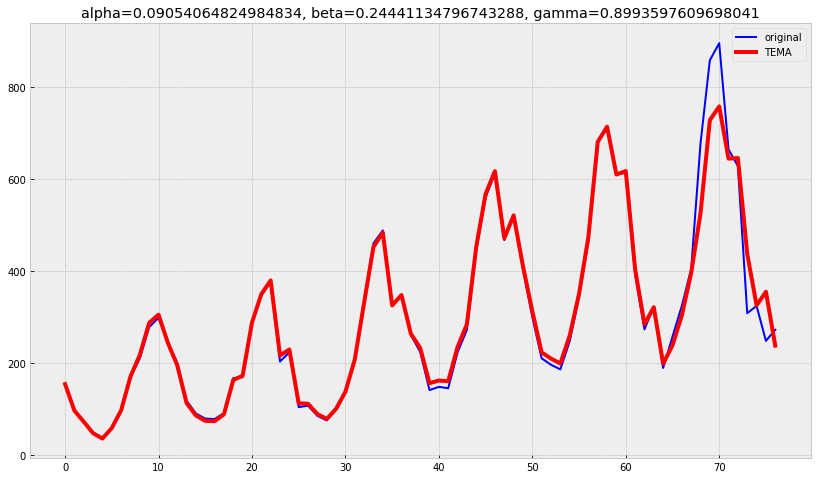

In [50]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))